In [1]:
1+1

2

In [2]:
# kernal: Python3

In [3]:
import itertools
import traceback
import random, numpy as np
import os, glob, pathlib, sys
import openpyxl
import re
import csv
import pandas as pd
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from pycaret.classification import setup, compare_models, plot_model, pull, ClassificationExperiment, blend_models, stack_models, finalize_model, predict_model, save_model, models, create_model
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.model_selection import StratifiedKFold
from pycaret.classification import get_config
from sklearn.inspection import permutation_importance
import shap

/home/seokjune/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [4]:
MSI1 = pd.read_csv("/home/seokjune2/SLC/ICI/model_data/MSI1.csv", index_col=0)  # 70
MSI2 = pd.read_csv("/home/seokjune2/SLC/ICI/model_data/MSI2.csv", index_col=0)  # 41
MSS1 = pd.read_csv("/home/seokjune2/SLC/ICI/model_data/MSS1.csv", index_col=0)  # 9
MSS2 = pd.read_csv("/home/seokjune2/SLC/ICI/model_data/MSS2.csv", index_col=0)  # 34
MSS3 = pd.read_csv("/home/seokjune2/SLC/ICI/model_data/MSS3.csv", index_col=0)  # 12

for _df, t in [(MSI1,"MSI"),(MSI2,"MSI"),(MSS1,"MSS"),(MSS2,"MSS"),(MSS3,"MSS")]:
    _df["type"] = t

want_cols = ["SLC39A2","SLC39A4","SLC39A5","SLC39A10","CDX2","CD24","SIGLEC10","Response","type"]

datasets = {
    "MSS1": MSS1, "MSS2": MSS2, "MSS3": MSS3,
    "MSI1": MSI1, "MSI2": MSI2
}


modeling_parts, external_parts = [], []

for name, d in datasets.items():
    d_sel = d.reindex(columns=want_cols).copy()
    d_sel.index.name = "Sample"
    d_sel["dataset"] = name

    
    d_model, d_ext = train_test_split(
        d_sel, test_size=0.15, random_state=2025, shuffle=True
    )
    modeling_parts.append(d_model)
    external_parts.append(d_ext)

modeling_df = pd.concat(modeling_parts, axis=0)
external_df = pd.concat(external_parts, axis=0)

dataset_counts = pd.DataFrame({
    "Modeling": modeling_df["dataset"].value_counts(normalize=True),
    "External": external_df["dataset"].value_counts(normalize=True)
}).fillna(0) * 100

print("### Dataset split ratio (%)")
display(dataset_counts.round(2))


# ==== Response split ratio table ====
resp_counts = pd.DataFrame({
    "Modeling": modeling_df["Response"].value_counts(normalize=True),
    "External": external_df["Response"].value_counts(normalize=True)
}).fillna(0) * 100

print("### Response split ratio (%)")
display(resp_counts.round(2))

### Dataset split ratio (%)


,Modeling,External
MSI1,42.75,39.29
MSI2,24.64,25.00
MSS1,5.07,7.14
MSS2,20.29,21.43
MSS3,7.25,7.14


### Response split ratio (%)


,Modeling,External
R,62.32,53.57
NR,37.68,46.43


In [5]:
def _prep(df):
    df = df.dropna(subset=["Response","type"])  # 필수 컬럼 누락 제거
    # Response를 문자열 레이블로 통일(예: 0/1 -> "0"/"1" 또는 "NR/CR")
    df["Response"] = df["Response"].astype(str)
    df["strata"] = df["type"].astype(str) + "__" + df["Response"]
    return df

modeling_df = _prep(modeling_df)
external_df     = _prep(external_df)

In [6]:
SEED = 2025
test_sizes     = 0.10
fold_values    = 5
fold_shuffles  = True
normalizes     = True
fix_imbalances = False
n_select_list  = 1

include_models = ["lr","rf","gbc","xgboost","lightgbm","et","knn","nb","qda","lda","dt","ada","svm","ridge"]

def _safe(s):
    return re.sub(r'[^A-Za-z0-9_.-]+', '_', str(s))
master_rows = []

In [7]:
train_df = modeling_df.copy()

In [8]:
setup(data=train_df,
      target="Response",
      session_id=SEED,
      fold_strategy="stratifiedkfold",
      fold=fold_values,
      fold_shuffle=fold_shuffles,
      normalize=normalizes,
      fix_imbalance=fix_imbalances,
      ignore_features=["type","strata","dataset"] if "strata" in train_df.columns else ["type"],
      verbose=False
     )

In [9]:
compare_models(sort="AUC", n_select=n_select_list)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.6874,0.7262,0.8167,0.7203,0.7648,0.3024,0.3111,8.3560
ada,Ada Boost Classifier,0.6253,0.6735,0.6833,0.7072,0.6900,0.2080,0.2128,7.9100
et,Extra Trees Classifier,0.6563,0.6515,0.8333,0.6863,0.7518,0.2074,0.2170,8.5420
xgboost,Extreme Gradient Boosting,0.6458,0.6314,0.7333,0.7108,0.7211,0.2352,0.2363,12.1160
rf,Random Forest Classifier,0.6674,0.6263,0.8333,0.6946,0.7571,0.2391,0.2524,7.7900
lightgbm,Light Gradient Boosting Machine,0.5937,0.6010,0.7500,0.6484,0.6934,0.0956,0.1011,13.1680
knn,K Neighbors Classifier,0.6374,0.5900,0.8500,0.6598,0.7414,0.1456,0.1666,6.0180
dt,Decision Tree Classifier,0.5942,0.5768,0.6500,0.6897,0.6647,0.1492,0.1528,6.6080
lr,Logistic Regression,0.6447,0.5747,0.8667,0.6725,0.7517,0.1447,0.1688,6.8760
lda,Linear Discriminant Analysis,0.6242,0.5744,0.8333,0.6643,0.7338,0.1060,0.1208,12.9880


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=2025, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [10]:
lb = pull().copy().reset_index()
lb

,index,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,gbc,Gradient Boosting Classifier,0.6874,0.7262,0.8167,0.7203,0.7648,0.3024,0.3111,8.356
1,ada,Ada Boost Classifier,0.6253,0.6735,0.6833,0.7072,0.6900,0.2080,0.2128,7.910
2,et,Extra Trees Classifier,0.6563,0.6515,0.8333,0.6863,0.7518,0.2074,0.2170,8.542
3,xgboost,Extreme Gradient Boosting,0.6458,0.6314,0.7333,0.7108,0.7211,0.2352,0.2363,12.116
4,rf,Random Forest Classifier,0.6674,0.6263,0.8333,0.6946,0.7571,0.2391,0.2524,7.790
5,lightgbm,Light Gradient Boosting Machine,0.5937,0.6010,0.7500,0.6484,0.6934,0.0956,0.1011,13.168
6,knn,K Neighbors Classifier,0.6374,0.5900,0.8500,0.6598,0.7414,0.1456,0.1666,6.018
7,dt,Decision Tree Classifier,0.5942,0.5768,0.6500,0.6897,0.6647,0.1492,0.1528,6.608
8,lr,Logistic Regression,0.6447,0.5747,0.8667,0.6725,0.7517,0.1447,0.1688,6.876
9,lda,Linear Discriminant Analysis,0.6242,0.5744,0.8333,0.6643,0.7338,0.1060,0.1208,12.988


In [11]:
skf = StratifiedKFold(n_splits=5, shuffle=False)
for i, (tr_idx, va_idx) in enumerate(skf.split(modeling_df, modeling_df["Response"]), start=1):
    print(f"Fold {i}: Train = {len(tr_idx)}, Valid = {len(va_idx)}")

Fold 1: Train = 110, Valid = 28
Fold 2: Train = 110, Valid = 28
Fold 3: Train = 110, Valid = 28
Fold 4: Train = 111, Valid = 27
Fold 5: Train = 111, Valid = 27


In [12]:
mdl = create_model('gbc')
pull().copy().reset_index()
my_mdl = finalize_model(mdl)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7000,0.6667,0.8333,0.7143,0.7692,0.3478,0.3563
1,0.7368,0.7381,0.8333,0.7692,0.8000,0.4172,0.4200
2,0.6316,0.6786,0.7500,0.6923,0.7200,0.1840,0.1853
3,0.7368,0.8810,0.9167,0.7333,0.8148,0.3791,0.4085
4,0.6316,0.6667,0.7500,0.6923,0.7200,0.1840,0.1853
Mean,0.6874,0.7262,0.8167,0.7203,0.7648,0.3024,0.3111
Std,0.0475,0.0818,0.0624,0.0289,0.0394,0.0991,0.1049


In [13]:
cols = get_config('X_train_transformed').columns
fi = pd.DataFrame({
    'feature': cols,
    'importance': my_mdl.feature_importances_
}).sort_values('importance', ascending=False)
fi

,feature,importance
5,CD24,0.243977
4,CDX2,0.225569
0,SLC39A2,0.164645
3,SLC39A10,0.137900
1,SLC39A4,0.086670
6,SIGLEC10,0.079684
2,SLC39A5,0.061555


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.6429,0.7282,0.7333,0.6471,0.6875,0.2746,0.2775


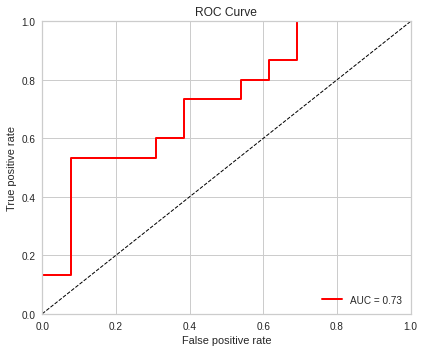

In [14]:
pred = predict_model(my_mdl, data=external_df, raw_score=True)
proba = None; pos_label = None
label_cols = [c for c in pred.columns if c.lower().startswith("label ")]   # e.g. 'Label 0','Label 1'
score_cols = [c for c in pred.columns if c.lower().startswith("score_")]   # e.g. 'Score_0','Score_1'

if len(label_cols) >= 2:
    pos_label = "1" if any(c.endswith(" 1") for c in label_cols) else label_cols[-1].split(" ",1)[1]
    proba = pred[[c for c in label_cols if c.endswith(" "+pos_label)][0]].values
elif len(score_cols) >= 2:
    pos_label = "1" if any(c.endswith("_1") for c in score_cols) else score_cols[-1].split("_",1)[1]
    proba = pred[[c for c in score_cols if c.endswith("_"+pos_label)][0]].values
else:
    proba = pred.iloc[:, -1].values  # 마지막 열이 확률이라고 가정
    pos_label = sorted(np.unique(external_df["Response"].astype(str)))[-1]

# 2) y_true 이진화
y_true = external_df["Response"].astype(str).values
y_bin = (y_true == pos_label).astype(int)


fpr, tpr, _ = roc_curve(y_bin, proba)
auc = roc_auc_score(y_bin, proba)

# ====== [여기에 추가] 캐시에 내 ROC 저장 ======
try:
    ROC_CACHE
except NameError:
    ROC_CACHE = {}
ROC_CACHE["My"] = {
    "fpr": fpr,
    "tpr": tpr,
    "auc": float(auc),
    "label": f"My model (AUC={auc:.2f})",
    "color": "red",
}
# ===========================================

# (원래 그리던 단일 플롯 – 필요하면 유지)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="red", linewidth=2, label=f"AUC = {auc:.2f}")
plt.plot([0,1], [0,1], linestyle="--", color="black", linewidth=1)
plt.plot([0,0,1], [0,1,1], 'k:', linewidth=1)
plt.xlim([0,1]); plt.ylim([0,1])
plt.xlabel('False positive rate'); plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Other dataset

In [15]:
df = pd.read_csv("/home/seokjune/ICI_modeling/benchmarking_ref/ref_geneset.csv", dtype=str,index_col=0) 
col_to_list = {c: df[c].dropna().tolist() for c in df.columns}

In [16]:
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
random.seed(SEED); np.random.seed(SEED)

pmid2lb = []
pmid_tables = {}
pmid2model = {}        # ← PMID별 최종 모델 저장
pmid2_splits = {}      # ← 원하면 각 PMID의 (modeling_df, external_df)도 저장

for pmid, genes in col_to_list.items():
    # 1) want_cols = genes + meta
    want_cols = list(dict.fromkeys(list(genes) + ["Response","type"]))  # 순서 유지

   
    modeling_parts, external_parts = [], []
    for name, d in datasets.items():
        d_sel = d.reindex(columns=want_cols).copy()
        d_sel.index.name = "Sample"
        d_sel["dataset"] = name
        feat_cols = [c for c in d_sel.columns if c not in ["Response","type","dataset"]]
        d_sel[feat_cols] = d_sel[feat_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0)

        d_model, d_ext = train_test_split(d_sel, test_size=0.15, random_state=SEED, shuffle=True)
        modeling_parts.append(d_model); external_parts.append(d_ext)

    modeling_df = pd.concat(modeling_parts, axis=0)
    external_df = pd.concat(external_parts, axis=0)

    # 3) 전처리
    modeling_df = _prep(modeling_df)
    external_df = _prep(external_df)
    pmid2_splits[pmid] = (modeling_df, external_df)

    # 4) PyCaret 세션
    setup(
        data=modeling_df,
        target="Response",
        session_id=2025,
        fold_strategy="stratifiedkfold",
        fold=5,
        fold_shuffle=True,
        normalize=True,
        fix_imbalance=False,
        ignore_features=["type","strata","dataset"] if "strata" in modeling_df.columns else ["type","dataset"],
        verbose=False
    )

    # 5) 모델 학습 + 최종화
    mdl = create_model('gbc')
    final_mdl = finalize_model(mdl)      # ← 여기서 최종 모델 확보
    pmid2model[pmid] = final_mdl         # ← PMID 키로 저장

    # 6) CV 리더보드 수집(원하면)
    lb = pull().copy().reset_index()
    lb["PMID"] = pmid
    pmid2lb.append(lb)
    pmid_tables[pmid] = lb

# 모든 PMID 리더보드 합치기(옵션)
lb_all = pd.concat(pmid2lb, ignore_index=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6500,0.6042,0.9167,0.6471,0.7586,0.1860,0.2287
1,0.7368,0.6905,0.8333,0.7692,0.8000,0.4172,0.4200
2,0.6316,0.7143,0.8333,0.6667,0.7407,0.1307,0.1409
3,0.6842,0.6071,0.7500,0.7500,0.7500,0.3214,0.3214
4,0.6316,0.6667,0.7500,0.6923,0.7200,0.1840,0.1853
Mean,0.6668,0.6565,0.8167,0.7051,0.7539,0.2479,0.2593
Std,0.0399,0.0442,0.0624,0.0472,0.0264,0.1055,0.1001


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7000,0.6354,0.9167,0.6875,0.7857,0.3182,0.3572
1,0.6842,0.6310,0.9167,0.6875,0.7857,0.2297,0.2677
2,0.6842,0.6310,0.8333,0.7143,0.7692,0.2785,0.2869
3,0.5789,0.5417,0.7500,0.6429,0.6923,0.0380,0.0391
4,0.6842,0.7619,0.7500,0.7500,0.7500,0.3214,0.3214
Mean,0.6663,0.6402,0.8333,0.6964,0.7566,0.2372,0.2545
Std,0.0441,0.0703,0.0745,0.0353,0.0347,0.1050,0.1119


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6000,0.7292,0.7500,0.6429,0.6923,0.1304,0.1336
1,0.6316,0.6071,0.8333,0.6667,0.7407,0.1307,0.1409
2,0.5789,0.6548,0.5833,0.7000,0.6364,0.1461,0.1495
3,0.5789,0.6429,0.6667,0.6667,0.6667,0.0952,0.0952
4,0.6316,0.6071,0.9167,0.6471,0.7586,0.0699,0.0936
Mean,0.6042,0.6482,0.7500,0.6646,0.6989,0.1145,0.1226
Std,0.0236,0.0447,0.1179,0.0202,0.0454,0.0278,0.0235


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8000,0.6875,0.8333,0.8333,0.8333,0.5833,0.5833
1,0.6316,0.6429,0.8333,0.6667,0.7407,0.1307,0.1409
2,0.6316,0.5833,0.6667,0.7273,0.6957,0.2312,0.2326
3,0.5263,0.6667,0.5833,0.6364,0.6087,0.0116,0.0116
4,0.6316,0.6786,0.7500,0.6923,0.7200,0.1840,0.1853
Mean,0.6442,0.6518,0.7333,0.7112,0.7197,0.2282,0.2308
Std,0.0879,0.0374,0.0972,0.0680,0.0725,0.1921,0.1910


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6000,0.6562,0.5833,0.7000,0.6364,0.2000,0.2041
1,0.6842,0.5357,0.8333,0.7143,0.7692,0.2785,0.2869
2,0.6842,0.7024,0.9167,0.6875,0.7857,0.2297,0.2677
3,0.5263,0.5357,0.5833,0.6364,0.6087,0.0116,0.0116
4,0.6316,0.4762,0.8333,0.6667,0.7407,0.1307,0.1409
Mean,0.6253,0.5812,0.7500,0.6810,0.7081,0.1701,0.1822
Std,0.0590,0.0842,0.1394,0.0272,0.0719,0.0926,0.0996


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7500,0.7917,0.8333,0.7692,0.8000,0.4681,0.4708
1,0.5263,0.6548,0.7500,0.6000,0.6667,-0.1176,-0.1268
2,0.7368,0.7024,0.8333,0.7692,0.8000,0.4172,0.4200
3,0.5789,0.5714,0.7500,0.6429,0.6923,0.0380,0.0391
4,0.4737,0.3214,0.5833,0.5833,0.5833,-0.1310,-0.1310
Mean,0.6132,0.6083,0.7500,0.6729,0.7085,0.1349,0.1344
Std,0.1115,0.1602,0.0913,0.0810,0.0830,0.2587,0.2617


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5500,0.6875,0.6667,0.6154,0.6400,0.0426,0.0428
1,0.5789,0.4643,0.7500,0.6429,0.6923,0.0380,0.0391
2,0.5263,0.5357,0.5833,0.6364,0.6087,0.0116,0.0116
3,0.4737,0.5357,0.5833,0.5833,0.5833,-0.1310,-0.1310
4,0.7368,0.4881,1.0000,0.7059,0.8276,0.3357,0.4491
Mean,0.5732,0.5423,0.7167,0.6368,0.6704,0.0594,0.0823
Std,0.0888,0.0777,0.1546,0.0403,0.0866,0.1520,0.1941


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6500,0.6562,0.7500,0.6923,0.7200,0.2553,0.2568
1,0.5263,0.4643,0.6667,0.6154,0.6400,-0.0491,-0.0494
2,0.5263,0.5476,0.6667,0.6154,0.6400,-0.0491,-0.0494
3,0.5789,0.5714,0.6667,0.6667,0.6667,0.0952,0.0952
4,0.6842,0.6667,0.8333,0.7143,0.7692,0.2785,0.2869
Mean,0.5932,0.5812,0.7167,0.6608,0.6872,0.1062,0.1080
Std,0.0643,0.0746,0.0667,0.0400,0.0504,0.1416,0.1441


In [17]:
row_label_col = next((c for c in lb_all.columns if lb_all[c].astype(str).str.contains("^Mean$").any()), None)
metrics = ["Accuracy","AUC","Recall","Prec.","F1","Kappa","MCC"]
res = (lb_all.loc[lb_all[row_label_col] == "Mean", ["PMID"] + metrics] .copy() .rename(columns={}))
my_row = {"PMID": "My", "Accuracy": 0.6874, "AUC": 0.7262, "Recall": 0.8167, "Prec.": 0.7203, "F1": 0.7648, "Kappa": 0.3024, "MCC": 0.3111}
res = pd.concat([res, pd.DataFrame([my_row])], ignore_index=True)
res


,PMID,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,PMID30309915,0.6668,0.6565,0.8167,0.7051,0.7539,0.2479,0.2593
1,PMID37497337,0.6663,0.6402,0.8333,0.6964,0.7566,0.2372,0.2545
2,PMID28650338,0.6042,0.6482,0.7500,0.6646,0.6989,0.1145,0.1226
3,PMID26997480,0.6442,0.6518,0.7333,0.7112,0.7197,0.2282,0.2308
4,PMID38538696,0.6253,0.5812,0.7500,0.6810,0.7081,0.1701,0.1822
5,PMID38664705,0.6132,0.6083,0.7500,0.6729,0.7085,0.1349,0.1344
6,PMID35254400,0.5732,0.5423,0.7167,0.6368,0.6704,0.0594,0.0823
7,PMID37022350,0.5932,0.5812,0.7167,0.6608,0.6872,0.1062,0.1080
8,My,0.6874,0.7262,0.8167,0.7203,0.7648,0.3024,0.3111


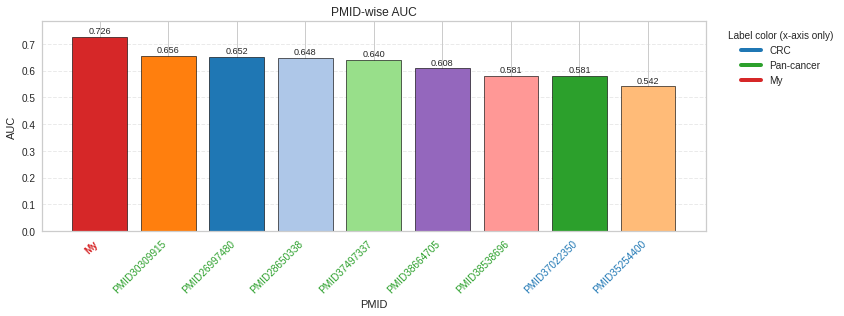

In [18]:
blue_pmids = {"PMID35254400", "PMID31788072", "PMID37022350"}  # CRC

COLOR_MY   = "#d62728"  # red
COLOR_CRC  = "#1f77b4"  # blue
COLOR_PAN  = "#2ca02c"  # green

def resolve_label_color(pmid: str) -> str:
    if pmid == "My":
        return COLOR_MY
    return COLOR_CRC if pmid in blue_pmids else COLOR_PAN

def _extract_proba_and_poslabel(pred_df: pd.DataFrame, y_true_series: pd.Series):

    cols = pred_df.columns
    label_cols = [c for c in cols if c.lower().startswith("label ")]
    score_cols = [c for c in cols if c.lower().startswith("score_")]

    if len(label_cols) >= 2:
        pos_label = "1" if any(c.endswith(" 1") for c in label_cols) else label_cols[-1].split(" ", 1)[1]
        proba_col = [c for c in label_cols if c.endswith(" " + pos_label)][0]
        proba = pred_df[proba_col].values
    elif len(score_cols) >= 2:
        pos_label = "1" if any(c.endswith("_1") for c in score_cols) else score_cols[-1].split("_", 1)[1]
        proba_col = [c for c in score_cols if c.endswith("_" + pos_label)][0]
        proba = pred_df[proba_col].values
    else:
        proba = pred_df.iloc[:, -1].values
        pos_label = sorted(np.unique(y_true_series.astype(str)))[-1]

    return proba, str(pos_label)

# ROC 캐시 준비
try:
    ROC_CACHE
except NameError:
    ROC_CACHE = {}

def _store_roc(key, fpr, tpr, auc, pos_label, n_samples, color=None, label=None):
    """ROC_CACHE에 표준 포맷으로 저장."""
    ROC_CACHE[key] = {
        "fpr": np.asarray(fpr),
        "tpr": np.asarray(tpr),
        "auc": float(auc),
        "pos_label": str(pos_label),
        "n": int(n_samples),
        "label": label if label is not None else f"{key} (AUC={auc:.2f})",
        "color": color,  # None이면 이후에 주입
    }

if "My" in ROC_CACHE:
    if "pos_label" not in ROC_CACHE["My"]:
        ROC_CACHE["My"]["pos_label"] = "1"
    if "n" not in ROC_CACHE["My"]:
        ROC_CACHE["My"]["n"] = len(ROC_CACHE["My"]["fpr"])


import colorsys

def _rgb_tuple(c):
    import matplotlib.colors as mcolors
    return mcolors.to_rgb(c)

def _dist_rgb(c1, c2):
    return np.linalg.norm(np.array(c1) - np.array(c2))

def generate_distinct_palette(n_needed, exclude_colors=()):

    base = [plt.cm.tab20(i)[:3] for i in range(20)]  # (r,g,b,1) → (r,g,b)
    excl = [ _rgb_tuple(c) for c in exclude_colors ]

    filtered = []
    for c in base:
        if all(_dist_rgb(c, e) > 0.25 for e in excl):  # 임계값 0.25 (필요시 조정)
            filtered.append(c)

    colors = []
    for c in filtered:
        if len(colors) >= n_needed:
            break
        if all(_dist_rgb(c, s) > 0.18 for s in colors):  # 임계값 0.18
            colors.append(c)

    i = 0
    while len(colors) < n_needed:
        # hue를 골고루, 다만 빨강 근처(−0.05~0.05)를 피함
        hue = ((i / max(1, n_needed)) + 0.1) % 1.0
        if 0.95 <= hue or hue <= 0.05:
            hue = (hue + 0.1) % 1.0
        r, g, b = colorsys.hsv_to_rgb(hue, 0.65, 0.85)
        cand = (r, g, b)
        if all(_dist_rgb(cand, e) > 0.25 for e in excl) and all(_dist_rgb(cand, s) > 0.18 for s in colors):
            colors.append(cand)
        i += 1

    return colors[:n_needed]


df = res.loc[:, ["PMID", "AUC"]].copy()
df = df.sort_values("AUC", ascending=False).reset_index(drop=True)

keys_from_res   = set(df["PMID"].tolist())
keys_from_cache = set(ROC_CACHE.keys())
keys_from_pmids = set(pmid2model.keys())  # 벤치마킹 모델 키
all_keys = keys_from_res | keys_from_cache | keys_from_pmids

other_keys = sorted([k for k in all_keys if k != "My"])

n_other = len(other_keys)
palette_other = generate_distinct_palette(n_other, exclude_colors=(COLOR_MY,))
COLOR_REG = {"My": COLOR_MY}
for k, c in zip(other_keys, palette_other):
    COLOR_REG[k] = c  # (r,g,b) 튜플 형태 OK


fig = plt.figure(figsize=(10, 4.5))
ax = plt.gca()

bar_colors = [COLOR_REG.get(pmid, (0.3,0.3,0.3)) for pmid in df["PMID"]]
bars = ax.bar(df["PMID"], df["AUC"], color=bar_colors, edgecolor="black", linewidth=0.6)

for b in bars:
    h = b.get_height()
    ax.text(b.get_x() + b.get_width()/2, h + 0.005, f"{h:.3f}",
            ha="center", va="bottom", fontsize=9)

ax.set_ylabel("AUC")
ax.set_xlabel("PMID")
ax.set_ylim(0, float(df["AUC"].max())*1.08)
ax.set_title("PMID-wise AUC")
ax.grid(axis="y", linestyle="--", alpha=0.4)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

for tick in ax.get_xticklabels():
    lab = tick.get_text()
    tick.set_color(resolve_label_color(lab))
    if lab == "My":
        tick.set_fontweight("bold")

legend_handles = [
    Line2D([0],[0], color=COLOR_CRC, lw=4, label="CRC"),
    Line2D([0],[0], color=COLOR_PAN, lw=4, label="Pan-cancer"),
    Line2D([0],[0], color=COLOR_MY,  lw=4, label="My"),
]
ax.legend(
    handles=legend_handles,
    title="Label color (x-axis only)",
    frameon=False,
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0)
)
#fig.savefig("/home/seokjune/ICI_modeling/model_validation_auc.pdf", format="pdf", bbox_inches="tight")
plt.show()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.6786,0.6308,0.8000,0.6667,0.7273,0.3438,0.3523


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.5000,0.6103,0.6667,0.5263,0.5882,-0.0262,-0.0274


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.6429,0.6821,0.8000,0.6316,0.7059,0.2670,0.2793


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.5714,0.6462,0.6667,0.5882,0.6250,0.1295,0.1309


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.5714,0.6462,0.8667,0.5652,0.6842,0.1016,0.1269


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.6071,0.6821,0.8000,0.6000,0.6857,0.1895,0.2038


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.5714,0.6256,0.7333,0.5789,0.6471,0.1204,0.1260


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.5000,0.5385,0.6667,0.5263,0.5882,-0.0262,-0.0274


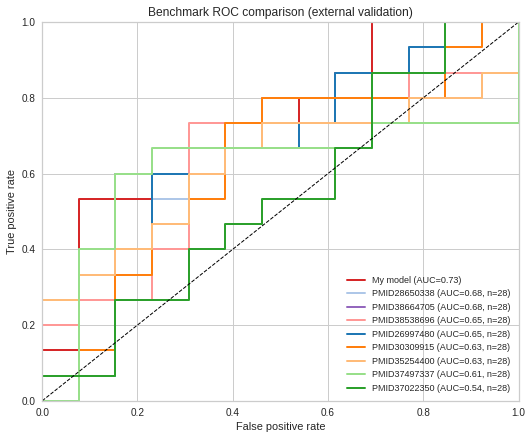

In [19]:
for pmid, final_mdl in pmid2model.items():

    modeling_df, external_df = pmid2_splits[pmid]
    y_true = external_df["Response"].astype(str)

    pred = predict_model(final_mdl, data=external_df, raw_score=True)
    proba, pos_label = _extract_proba_and_poslabel(pred, y_true)

    y_bin = (y_true.values == pos_label).astype(int)
    fpr, tpr, _ = roc_curve(y_bin, proba)
    auc = roc_auc_score(y_bin, proba)

    label = f"{pmid} (AUC={auc:.2f}, n={len(y_bin)})"
    _store_roc(
        pmid, fpr, tpr, auc, pos_label,
        n_samples=len(y_bin),
        color=COLOR_REG.get(pmid, None),
        label=label
    )

if "My" in ROC_CACHE:
    ROC_CACHE["My"]["color"] = COLOR_MY

for k in ROC_CACHE.keys():
    if k not in COLOR_REG:
        if k == "My":
            COLOR_REG[k] = COLOR_MY
        else:
            # 여분 색 하나 생성해서 추가
            extra = generate_distinct_palette(1, exclude_colors=tuple(COLOR_REG.values()) + (COLOR_MY,))
            COLOR_REG[k] = extra[0]
    ROC_CACHE[k]["color"] = COLOR_REG[k]


order_keys = sorted(ROC_CACHE.keys(), key=lambda k: ROC_CACHE[k]["auc"], reverse=True)

fig = plt.figure(figsize=(7.5, 6.2))
for k in order_keys:
    r = ROC_CACHE[k]
    plt.plot(
        r["fpr"], r["tpr"], lw=2,
        label=r.get("label", f"{k} (AUC={r['auc']:.2f})"),
        color=r["color"]
    )

# 기준선/완벽 모서리
plt.plot([0, 1], [0, 1], linestyle="--", color="black", linewidth=1)
plt.plot([0, 0, 1], [0, 1, 1], 'k:', linewidth=1)

plt.xlim([0, 1]); plt.ylim([0, 1])
plt.xlabel("False positive rate"); plt.ylabel("True positive rate")
plt.title("Benchmark ROC comparison (external validation)")
plt.legend(loc="lower right", fontsize=9, frameon=False)
plt.tight_layout()
#fig.savefig("/home/seokjune/ICI_modeling/model_test_auc.pdf", format="pdf", bbox_inches="tight")
plt.show()

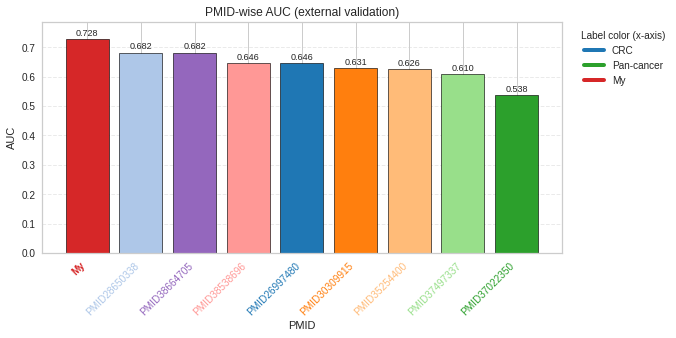

In [20]:
# --- AUC barplot from ROC_CACHE ---------------------------------
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

# 1) 데이터 정리
rows = []
for k, v in ROC_CACHE.items():
    rows.append({"PMID": k, "AUC": float(v["auc"]), "n": int(v.get("n", 0))})
df_bar = pd.DataFrame(rows)
# 표시 순서: AUC 내림차순
df_bar = df_bar.sort_values("AUC", ascending=False).reset_index(drop=True)

# 2) 색상 매핑 (COLOR_REG에 없는 키는 회색)
def _get_color(key):
    if "color" in ROC_CACHE[key] and ROC_CACHE[key]["color"] is not None:
        return ROC_CACHE[key]["color"]
    return COLOR_REG.get(key, (0.5, 0.5, 0.5))

bar_colors = [_get_color(k) for k in df_bar["PMID"]]

# 3) 플롯
fig, ax = plt.subplots(figsize=(9.5, 4.8))
bars = ax.bar(df_bar["PMID"], df_bar["AUC"], color=bar_colors, edgecolor="black", linewidth=0.6)

# AUC 숫자 표시
for b, auc, n in zip(bars, df_bar["AUC"], df_bar["n"]):
    ax.text(b.get_x()+b.get_width()/2, auc + 0.005, f"{auc:.3f}",
            ha="center", va="bottom", fontsize=9)

# 축/제목
ax.set_ylabel("AUC")
ax.set_xlabel("PMID")
ax.set_ylim(0, min(1.0, df_bar["AUC"].max()*1.08))
ax.set_title("PMID-wise AUC (external validation)")
ax.grid(axis="y", linestyle="--", alpha=0.4)
plt.xticks(rotation=45, ha="right")

# x축 라벨 색상/굵기(내 모델 강조)
for tick in ax.get_xticklabels():
    lab = tick.get_text()
    # ROC_CACHE에 저장된 색으로 x축 라벨도 칠하기
    tick.set_color(_get_color(lab))
    if lab == "My":
        tick.set_fontweight("bold")

# (선택) 범례 구성: 미리 쓰던 색 정의가 있다면 그대로 활용
legend_handles = []
if 'COLOR_CRC' in globals():
    legend_handles.append(Line2D([0],[0], color=COLOR_CRC, lw=4, label="CRC"))
if 'COLOR_PAN' in globals():
    legend_handles.append(Line2D([0],[0], color=COLOR_PAN, lw=4, label="Pan-cancer"))
if 'COLOR_MY' in globals():
    legend_handles.append(Line2D([0],[0], color=COLOR_MY, lw=4, label="My"))
if legend_handles:
    ax.legend(handles=legend_handles, title="Label color (x-axis)", frameon=False,
              loc="upper left", bbox_to_anchor=(1.02, 1.0))

plt.tight_layout()
fig.savefig("/home/seokjune/ICI_modeling/model_test_auc.pdf",
            format="pdf", bbox_inches="tight")
plt.show()